In [332]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter


In [333]:
iris_raw_data = pd.read_csv('iris.csv')
admission_raw_data = pd.read_csv('admission.csv')

In [334]:
iris_raw_data

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [335]:
iris_raw_data.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

In [336]:
admission_raw_data

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


In [337]:
admission_raw_data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

**Проверим пропуски в датасетах**

In [338]:
iris_raw_data.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [339]:
admission_raw_data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

**Проверим, равномерное ли распределение классов в датасете классификации**

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


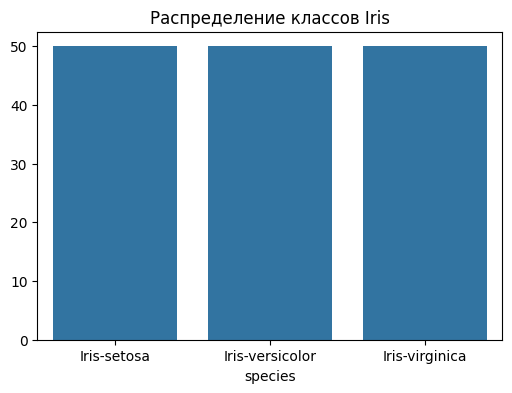

In [340]:
class_counts = iris_raw_data['species'].value_counts()
print(class_counts)
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Распределение классов Iris')
plt.show()

**БЕЙЗЛАЙН**

**Классификация**

Приступим к обучению базовой модели. Обучим пайплайн, состоящий из скэйлера и KNN классификатора

Датасет с цветками Ириса сбалансирован, поэтому Accuracy — это простая и понятная метрика, показывающая долю правильно классифицированных образцов.

In [341]:
X_cls = iris_raw_data.drop('species', axis=1)
y_cls = iris_raw_data['species']

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X_cls, y_cls, test_size=0.4, random_state=52)

knn_cls_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

knn_cls_baseline.fit(X_cls_train, y_cls_train)

y_cls_pred_base = knn_cls_baseline.predict(X_cls_test)
accuracy_base = accuracy_score(y_cls_test, y_cls_pred_base)

print(f"Accuracy (K=5) на тестовом наборе: {accuracy_base:.4f}")


Accuracy (K=5) на тестовом наборе: 0.9167


**Построим матрицу ошибок, чтобы посмотреть, какие классы чаще путаются между собой. Видим, что легче всего отделима setosa, а остальные два класса часто путаются**

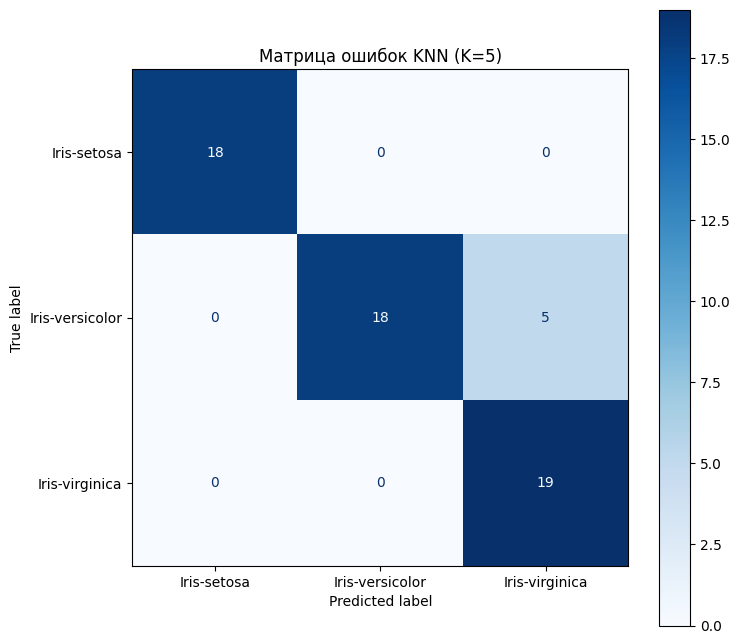

In [342]:
cm = confusion_matrix(y_cls_test, y_cls_pred_base, labels=knn_cls_baseline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_cls_baseline.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Матрица ошибок KNN (K=5)")
plt.show()

**Регрессия**

$R^2$ Score показывает, какую долю дисперсии целевой переменной объясняет модель. MAE дает оценку средней ошибки в абсолютных единицах целевой переменной. Для задачи регрессии будем использовать эти две метрики.

Выбросим признак серийного номера, это абстрактное число.

In [343]:
admission_raw_data = admission_raw_data.drop('Serial No.', axis=1)

Разделим датасет на предикторы и целевую переменную

In [344]:
X_reg = admission_raw_data.drop('Chance of Admit ', axis=1)
y_reg = admission_raw_data['Chance of Admit ']

Обучим бейзлайн

In [345]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

knn_reg_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

knn_reg_baseline.fit(X_reg_train, y_reg_train)

y_reg_pred_base = knn_reg_baseline.predict(X_reg_test)
r2_base = r2_score(y_reg_test, y_reg_pred_base)
mae_base = mean_absolute_error(y_reg_test, y_reg_pred_base)

print(f"R^2 Score (K=5) на тестовом наборе: **{r2_base:.4f}**")
print(f"MAE (K=5) на тестовом наборе: **{mae_base:.4f}**")


R^2 Score (K=5) на тестовом наборе: **0.7394**
MAE (K=5) на тестовом наборе: **0.0546**


**МОДИФИКАЦИИ**

**Классификация**

Посмотрим, как разделяются данные в пространствах каждой пары признаков

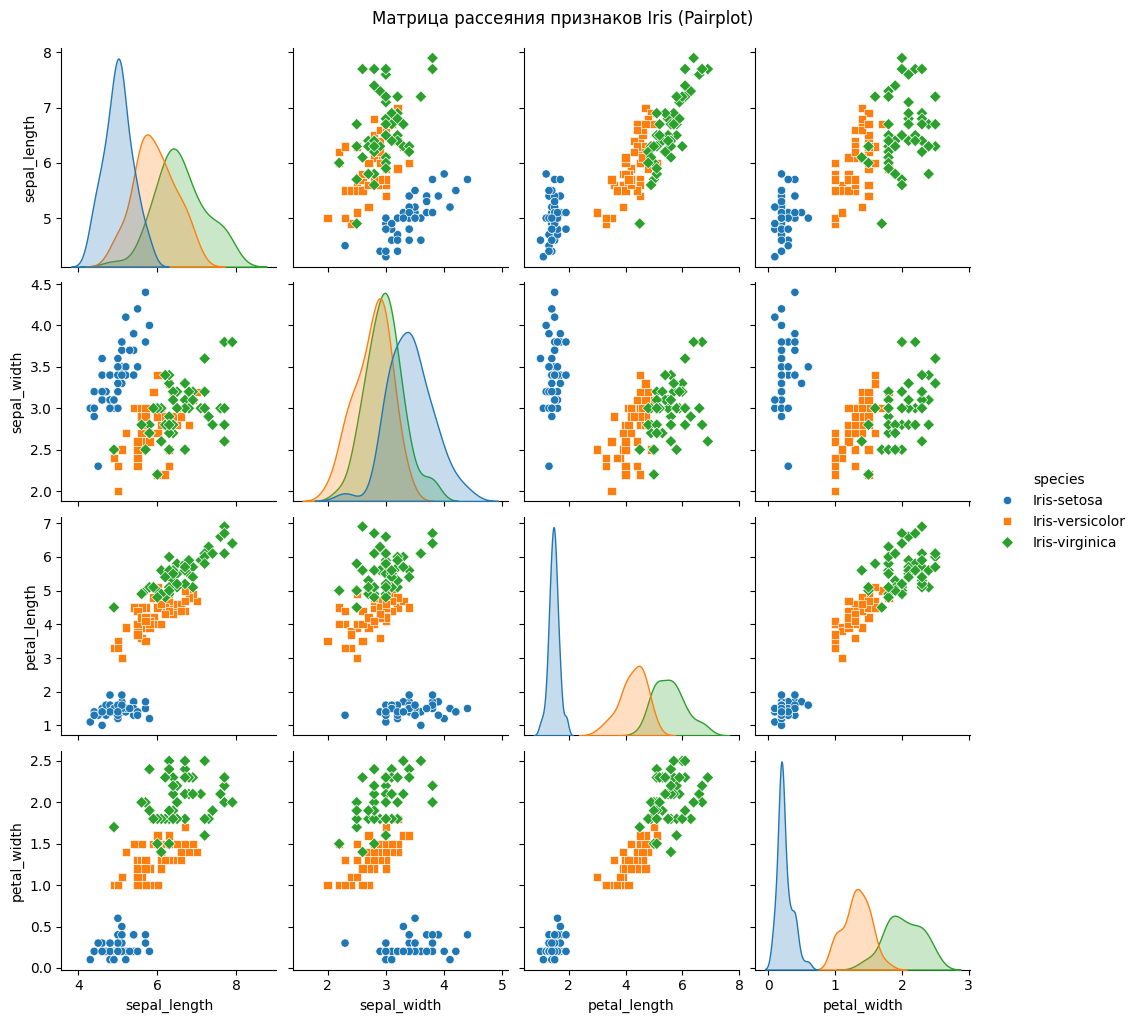

In [346]:
sns.pairplot(iris_raw_data, hue='species', markers=["o", "s", "D"])
plt.suptitle("Матрица рассеяния признаков Iris (Pairplot)", y=1.02)
plt.show()

Применим к данным анализ главных компонент, основанный на алгоритме SVD разложения.

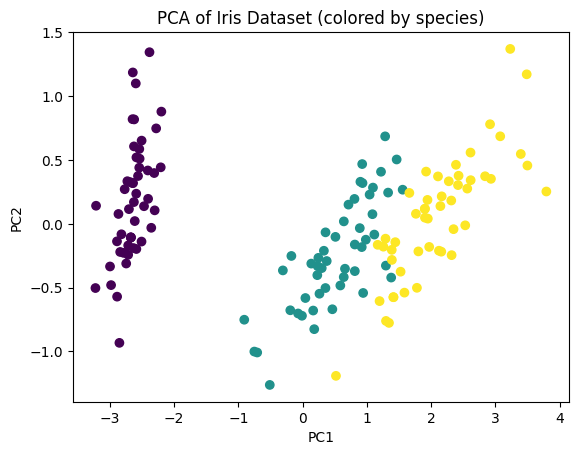

In [347]:
X = iris_raw_data.drop('species', axis=1)
y = iris_raw_data['species']

if not np.issubdtype(y.dtype, np.number):
    y_encoded = y.astype('category').cat.codes
else:
    y_encoded = y

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# plot
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_encoded)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Iris Dataset (colored by species)")
plt.show()

Видим, что в пространстве первых двух компонент данные лучше разделяются.

Улучшим результат классификации с помощью подбора параметров на кросс-валидации по сетке. Также добавим в пайплайн PCA - метод главных компонент. Он позволяет сформировать линейные комбинации существующих признаков так, чтобы их дисперсия была максимальной. Это позволяет сделать классы разделимее.

In [348]:
knn_cls_pca_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=3)), 
    ('knn', KNeighborsClassifier(n_neighbors=5)) 
])

param_grid = {
    'knn__n_neighbors': range(1, 10),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

print("Улучшение Классификации")
grid_cls = GridSearchCV(knn_cls_pca_pipeline, param_grid, cv=8, scoring='accuracy')
grid_cls.fit(X_cls_train, y_cls_train)


print("Лучшие параметры KNN:", grid_cls.best_params_)


knn_cls_improved = grid_cls.best_estimator_

Улучшение Классификации
Лучшие параметры KNN: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2, 'knn__weights': 'uniform'}


In [349]:
y_cls_pred_imp = knn_cls_improved.predict(X_cls_test)
accuracy_imp = accuracy_score(y_cls_test, y_cls_pred_imp)

print(f"Классификация :")
print(f"Accuracy Бейзлайн: {accuracy_base:.4f}")
print(f"Accuracy Улучшенный:   {accuracy_imp:.4f}")
cls_diff = accuracy_imp - accuracy_base
print(f"Разница в качестве:     {cls_diff:+.4f}")

Классификация :
Accuracy Бейзлайн: 0.9167
Accuracy Улучшенный:   0.9500
Разница в качестве:     +0.0333


**Результат улучшения KNN классификации**: увеличение метрики accuracy на 0.033. Это подтвердило эффективность подбора гиперпараметров на кросс-валидации и использование PCA.

**Регрессия**

In [350]:
knn_impoved_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

param_grid = {
    'knn__n_neighbors': range(1, 21),             
    'knn__weights': ['uniform', 'distance'], 
    'knn__metric': ['euclidean', 'manhattan'], 
    'knn__p': [1, 2]
}
reg_grid = GridSearchCV(
    knn_impoved_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
reg_grid.fit(X_reg_train, y_reg_train)

best_knn = reg_grid.best_estimator_

print("Лучшие параметры:", reg_grid.best_params_)


y_reg_pred = best_knn.predict(X_reg_test)

r2_best = r2_score(y_reg_test, y_reg_pred)
mae_best = mean_absolute_error(y_reg_test, y_reg_pred)

print(f"R^2 (best KNN) на тестовом наборе: {r2_best:.4f}")
print(f"MAE (best KNN) на тестовом наборе: {mae_best:.4f}")

print("\nСравнение с базовым KNN:")
print(f"R^2 базового:  {r2_base:.4f}")
print(f"R^2 лучшего:   {r2_best:.4f}")
print(f"MAE базового:  {mae_base:.4f}")
print(f"MAE лучшего:   {mae_best:.4f}")
mae_diff = mae_best - mae_base
r2_diff = r2_best - r2_base
print(f"Разница в MAE:     {mae_diff:+.4f}")
print(f"Разница в R^2:     {r2_diff:+.4f}")

Лучшие параметры: {'knn__metric': 'euclidean', 'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance'}
R^2 (best KNN) на тестовом наборе: 0.7547
MAE (best KNN) на тестовом наборе: 0.0535

Сравнение с базовым KNN:
R^2 базового:  0.7394
R^2 лучшего:   0.7547
MAE базового:  0.0546
MAE лучшего:   0.0535
Разница в MAE:     -0.0011
Разница в R^2:     +0.0153


**Результат улучшения KNN регрессии**: уменьшение метрики MAE на 0011. Увеличение метрики R2 на 0.0153. Это подтвердило эффективность подбора гиперпараметров на кросс-валидации.

**ИМПЛЕМЕНТАЦИЯ**

**KNN-классификация**

Напишем sklearn-подобный класс KNN-классификатора

In [351]:
class CustomKNeighborsClassifier:
    def __init__(self, n_neighbors=5):
        self.k = n_neighbors
        self._X_train = None
        self._y_train = None

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2)**2))

    def fit(self, X, y):
        self._X_train = X
        self._y_train = y
        return self

    def _predict_one(self, x_test_point):
        distances = []
        for i, x_train_point in enumerate(self._X_train):
            dist = self._euclidean_distance(x_test_point, x_train_point)
            distances.append((dist, self._y_train[i]))
            
        distances.sort(key=lambda x: x[0])
        k_neighbors_labels = [label for dist, label in distances[:self.k]]
        most_common = Counter(k_neighbors_labels).most_common(1)
        
        return most_common[0][0]

    def predict(self, X):
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)



Напишем фукнцию для подсчета метрики

In [352]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    return correct_predictions / total_samples

Напишем фукнцию для разбиения данных на тестовую и тренировочную выборку

In [353]:
def train_test_split(X, y, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    n_test = int(n_samples * test_size)
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

Выделим таргет и признаки и разобьем данные на тест и трейн

In [354]:
data = iris_raw_data.copy()
X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = data['species'].values

unique_species = np.unique(y)
species_map = {species: i for i, species in enumerate(unique_species)}
y_encoded = np.array([species_map[s] for s in y])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

Обучим модель, получим предсказания и посчитаем метрику

In [355]:
knn_model = CustomKNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train) 

y_pred = knn_model.predict(X_test)

accuracy = calculate_accuracy(y_test, y_pred)

print("\n Результаты Baseline Custom KNN ")
print(f"Размер тестового набора: {len(y_test)}")

print(f"Accuracy предсказаний:{accuracy:.4f}")


 Результаты Baseline Custom KNN 
Размер тестового набора: 60
Accuracy предсказаний:0.9833


Мы получили хорошее значение точности для имплементированного бейзлайна. Попробуем применить некоторые техники для того, чтобы сделать классы более разделимыми.

**Модификация. Реализация PCA.**

In [356]:
class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean_ = None
        self.components_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
        eigen_pairs.sort(key=lambda x: x[0], reverse=True)
        
        self.components_ = np.array([pair[1] for pair in eigen_pairs[:self.n_components]]).T
        
        return self

    def transform(self, X):
        X_centered = X - self.mean_
        X_transformed = X_centered.dot(self.components_)
        return X_transformed

Выделим предикторы и таргет и разобьем выборку на трейн и тест

In [357]:
data = iris_raw_data.copy()
X_full = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values
y = data['species'].values

unique_species = np.unique(y)
species_map = {species: i for i, species in enumerate(unique_species)}
y_encoded = np.array([species_map[s] for s in y])

X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y_encoded, test_size=0.4, random_state=42)

Применим PCA

In [358]:
pca = CustomPCA(n_components=2)
pca.fit(X_train_full)
X_train_pca = pca.transform(X_train_full)
X_test_pca = pca.transform(X_test_full)

Обучим KNN имплементацию, получим предсказания и посчитаем метрику

In [359]:
knn_model_pca = CustomKNeighborsClassifier(n_neighbors=5)
knn_model_pca.fit(X_train_pca, y_train) 
y_pred_pca = knn_model_pca.predict(X_test_pca)
accuracy_pca = calculate_accuracy(y_test, y_pred_pca)

print("\nРезультаты KNN на данных, преобразованных с помощью PCA (n_components=2)")
print(f"Размер тестового набора: {len(y_test)}")
print(f"Метрика Accuracy предсказаний: {accuracy_pca:.4f}")


Результаты KNN на данных, преобразованных с помощью PCA (n_components=2)
Размер тестового набора: 60
Метрика Accuracy предсказаний: 1.0000


**KNN-регрессия**

Реализуем класс KNN регрессора

In [360]:
class CustomKNeighborsRegressor:
    def __init__(self, n_neighbors=5):
        self.k = n_neighbors
        self._X_train = None
        self._y_train = None

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2)**2))

    def fit(self, X, y):
        self._X_train = X
        self._y_train = y
        return self

    def _predict_one(self, x_test_point):
        distances = []
        
        for i, x_train_point in enumerate(self._X_train):
            dist = self._euclidean_distance(x_test_point, x_train_point)
            distances.append((dist, self._y_train[i]))
            
        distances.sort(key=lambda x: x[0])
        k_neighbors_values = [value for dist, value in distances[:self.k]]
        
        prediction = np.mean(k_neighbors_values)
        
        return prediction

    def predict(self, X):
        predictions = [self._predict_one(x) for x in X]
        return np.array(predictions)

Реализуем функции для подсчета метрик

In [361]:
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_r2(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_res = np.sum((y_true - y_pred)**2)
    
    ss_tot = np.sum((y_true - y_mean)**2)
    if ss_tot == 0:
        return 1.0
        
    return 1 - (ss_res / ss_tot)

Реализуем класс скейлера, который приведет признаки к масштабу со средним равным ноль стандартным отклонением равным единице.

In [362]:
class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        self.scale_[self.scale_ == 0] = 1.0 
        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise RuntimeError("Scaler не обучен. Вызовите 'fit' перед 'transform'.")
        return (X - self.mean_) / self.scale_

Разделим данные на тренировочную и тестовую выборку и отскалируем их

In [363]:
admission_raw_data.columns = admission_raw_data.columns.str.strip()
feature_cols = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']
target_col = 'Chance of Admit'

X_full = admission_raw_data[feature_cols].values
y_full = admission_raw_data[target_col].values

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

In [364]:
scaler = CustomStandardScaler()
scaler.fit(X_train_orig)

X_train_scaled = scaler.transform(X_train_orig)
X_test_scaled = scaler.transform(X_test_orig)

print("\nПроверка стандартизации")
print(f"Среднее тренировочного набора (до): {X_train_orig.mean(axis=0).round(2)}")
print(f"Среднее тренировочного набора (после): {X_train_scaled.mean(axis=0).round(2)}")
print(f"Стд. отклонение тренировочного набора (после): {X_train_scaled.std(axis=0).round(2)}")


Проверка стандартизации
Среднее тренировочного набора (до): [317.17 107.63   3.11   3.41   3.45   8.6    0.56]
Среднее тренировочного набора (после): [-0. -0. -0.  0. -0. -0. -0.]
Стд. отклонение тренировочного набора (после): [1. 1. 1. 1. 1. 1. 1.]


In [365]:
knn_regressor_scaled = CustomKNeighborsRegressor(n_neighbors=5)

knn_regressor_scaled.fit(X_train_scaled, y_train) 

y_pred_scaled = knn_regressor_scaled.predict(X_test_scaled)

mae_scaled = calculate_mae(y_test, y_pred_scaled)
r2_scaled = calculate_r2(y_test, y_pred_scaled)

print("\nРезультаты Custom KNN Regressor на стандартизованных данных")
print(f"Метрика MAE: {mae_scaled:.4f}")
print(f"Метрика R^2 : {r2_scaled:.4f}")


Результаты Custom KNN Regressor на стандартизованных данных
Метрика MAE: 0.0546
Метрика R^2 : 0.7394


**Модификация. Подбор гиперпараметров по сетке.**

Имплементируем функции для разбиения выборки на фолды и для поиска по сетке

In [366]:
def custom_k_fold_split(X, y, n_splits=5, random_state=42):
    np.random.seed(random_state)
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
    fold_sizes[:n_samples % n_splits] += 1
    
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        test_indices = indices[start:stop]
        train_indices = np.concatenate([indices[:start], indices[stop:]])
        yield (train_indices, test_indices)
        current = stop

def custom_grid_search(X_train, y_train, model_class, param_grid, n_splits=5, scoring='r2'):
    
    best_score = -np.inf if scoring == 'r2' else np.inf
    best_params = {}
    
    for k in param_grid['n_neighbors']:

        fold_scores = []
        cv_splitter = custom_k_fold_split(X_train, y_train, n_splits=n_splits)
        
        for train_indices, val_indices in cv_splitter:
            X_train_fold, X_val_fold = X_train[train_indices], X_train[val_indices]
            y_train_fold, y_val_fold = y_train[train_indices], y_train[val_indices]
            
            model = model_class(n_neighbors=k)
            model.fit(X_train_fold, y_train_fold)
            
            y_val_pred = model.predict(X_val_fold)
            
            if scoring == 'r2':
                score = calculate_r2(y_val_fold, y_val_pred)
            elif scoring == 'mae':
                score = calculate_mae(y_val_fold, y_val_pred)
            else:
                raise ValueError("Метрика не поддерживается")
                
            fold_scores.append(score)
        
        mean_score = np.mean(fold_scores)
        
        if (scoring == 'r2' and mean_score > best_score) or \
           (scoring == 'mae' and mean_score < best_score):
            best_score = mean_score
            best_params = {'n_neighbors': k}
            
        print(f"  k={k}: Средняя {scoring.upper()} CV = {mean_score:.4f}")
        
    return best_params, best_score

Выделим предикторы и таргет. Разобьем датасет на трейн и тест.

In [367]:
admission_raw_data.columns = admission_raw_data.columns.str.strip()
feature_cols = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']
target_col = 'Chance of Admit'

X_full = admission_raw_data[feature_cols].values
y_full = admission_raw_data[target_col].values

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

Отмасштабируем выборку

In [368]:
scaler = CustomStandardScaler()
scaler.fit(X_train_orig)
X_train_scaled = scaler.transform(X_train_orig)
X_test_scaled = scaler.transform(X_test_orig)

Найдем оптимальные гиперпараметры по сетке

In [371]:
param_grid = {'n_neighbors': range(1,21)}
n_folds = 5
metric = 'r2'


best_params, best_cv_score = custom_grid_search(
    X_train_scaled, 
    y_train, 
    CustomKNeighborsRegressor, 
    param_grid, 
    n_splits=n_folds, 
    scoring=metric
)

print("\nРезультаты Grid Search")
print(f"Оптимальный параметр (k): {best_params['n_neighbors']}")
print(f"Лучшая средняя {metric.upper()} CV: {best_cv_score:.4f}")

  k=1: Средняя R2 CV = 0.5990
  k=2: Средняя R2 CV = 0.6746
  k=3: Средняя R2 CV = 0.7111
  k=4: Средняя R2 CV = 0.7246
  k=5: Средняя R2 CV = 0.7407
  k=6: Средняя R2 CV = 0.7469
  k=7: Средняя R2 CV = 0.7539
  k=8: Средняя R2 CV = 0.7496
  k=9: Средняя R2 CV = 0.7518
  k=10: Средняя R2 CV = 0.7551
  k=11: Средняя R2 CV = 0.7575
  k=12: Средняя R2 CV = 0.7527
  k=13: Средняя R2 CV = 0.7504
  k=14: Средняя R2 CV = 0.7501
  k=15: Средняя R2 CV = 0.7505
  k=16: Средняя R2 CV = 0.7528
  k=17: Средняя R2 CV = 0.7514
  k=18: Средняя R2 CV = 0.7528
  k=19: Средняя R2 CV = 0.7516
  k=20: Средняя R2 CV = 0.7528

Результаты Grid Search
Оптимальный параметр (k): 11
Лучшая средняя R2 CV: 0.7575


Обучим лучшую модель

In [372]:
final_k = best_params['n_neighbors']
final_model = CustomKNeighborsRegressor(n_neighbors=final_k)
final_model.fit(X_train_scaled, y_train) 

# Предсказание на тестовом наборе
y_pred_final = final_model.predict(X_test_scaled)

# Расчет финальных метрик
final_mae = calculate_mae(y_test, y_pred_final)
final_r2 = calculate_r2(y_test, y_pred_final)

print("\nФинальная Оценка Модели")
print(f"Модель обучена с k = {final_k}")
print(f"Финальная метрика MAE на тестовом наборе: {final_mae:.4f}")
print(f"Финальная метрика R2 на тестовом наборе: {final_r2:.4f}")

mae_diff = final_mae - mae_scaled
r2_diff = final_r2 - r2_scaled

print(f"Разница в MAE:     {mae_diff:+.4f}")
print(f"Разница в R^2:     {r2_diff:+.4f}")


Финальная Оценка Модели
Модель обучена с k = 11
Финальная метрика MAE на тестовом наборе: 0.0546
Финальная метрика R2 на тестовом наборе: 0.7447
Разница в MAE:     +0.0000
Разница в R^2:     +0.0053


**Результаты:** Видим улучшение результата после кросс-валидации. Получается, что в процессе кросс-валидации были подобраны оптимальные гиперпараметры, повлиявшие на качество модели